In [1]:
# default_exp calib

# Import

In [2]:
# export
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from camera_calib.control_refine import CheckerRefiner
from camera_calib.modules import (CamSF, Heikkila97Distortion, Inverse,
                                  Normalize, Rigid)
from camera_calib.utils import *

In [3]:
import re
from pathlib import Path

import pandas as pd
from IPython.core.debugger import set_trace

from camera_calib.cb_geom import CbGeom, CpCSRGrid, FmCFPGrid
from camera_calib.control_refine import OpenCVCheckerRefiner
from camera_calib.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib.image import File16bitImg

# Utility

Note that principle point initial guess, from my experience, is very unstable, so just set it to the middle of the image.

In [4]:
# export
@numpyify
def init_intrin(Hs, sz):
    assert_allclose(Hs[0].dtype, sz.dtype)    
    zero, one = Hs[0].new_tensor(0), Hs[0].new_tensor(1)
    yo, xo = (sz-1)/2
    po_inv = stackify((( one, zero, -xo),
                       (zero,  one, -yo),
                       (zero, zero, one)))
    A, b = [], []
    for H in Hs:
        H_bar = po_inv@H
        v1, v2 = H_bar[:,0], H_bar[:,1]
        v3, v4 = v1+v2, v1-v2
        v1, v2, v3, v4 = unitize(stackify((v1, v2, v3, v4)))
        A.append(stackify((v1[0]*v2[0]+v1[1]*v2[1], v3[0]*v4[0]+v3[1]*v4[1])))
        b.append(stackify((-v1[2]*v2[2], -v3[2]*v4[2])))
    A, b = map(torch.cat, [A, b])
    alpha = torch.sqrt(torch.dot(b,A)/torch.dot(b,b))
    return stackify(((alpha,  zero,  xo),
                     ( zero, alpha,  yo),
                     ( zero,  zero, one)))

In [5]:
Hs = (torch.Tensor([[-1.3616e+01, -1.3246e+01,  1.2562e+03],
                    [ 1.3679e+01, -1.3815e+01,  8.1943e+02],
                    [-7.6882e-04, -3.5803e-03,  1.0000e+00]]),)
sz = torch.Tensor([1536, 2048])
assert_allclose_f_ttn(init_intrin, (Hs, sz), torch.Tensor([[3.5509e+03, 0.0000e+00, 1.0235e+03],
                                                           [0.0000e+00, 3.5509e+03, 7.6750e+02],
                                                           [0.0000e+00, 0.0000e+00, 1.0000e+00]]), atol=1)

In [6]:
# export
@numpyify
def init_extrin(H, A):
    H_bar = torch.inverse(A)@H
    lambdas = torch.norm(H_bar, dim=0)
    r1, r2 = [H_bar[:,idx]/lambdas[idx] for idx in range(2)]
    r3 = torch.cross(r1, r2)
    R = approx_R(stackify((r1,r2,r3), dim=1))
    t = H_bar[:,2]/lambdas[0:2].mean()
    return R, t

In [7]:
H = torch.Tensor([[-1.3616e+01, -1.3246e+01,  1.2562e+03],
                  [ 1.3679e+01, -1.3815e+01,  8.1943e+02],
                  [-7.6882e-04, -3.5803e-03,  1.0000e+00]])
A = torch.Tensor([[3.5509e+03, 0.0000e+00, 1.0235e+03],
                  [0.0000e+00, 3.5509e+03, 7.6750e+02],
                  [0.0000e+00, 0.0000e+00, 1.0000e+00]])
assert_allclose_f_ttn(init_extrin, (H, A), (torch.Tensor([[-0.6621, -0.4944, -0.5631],
                                                          [ 0.7360, -0.5705, -0.3644],
                                                          [-0.1411, -0.6558,  0.7417]]),
                                            torch.Tensor([ 12.0041,   2.6789, 183.1772])), atol=1e-4)         

In [8]:
# export
def SSE(x1, x2): return ((x1-x2)**2).sum()

In [9]:
# export
def w2p_loss(w2ps, ps_c_w, pss_c_p, loss):
    ls = []
    for w2p, ps_c_p in zip(w2ps, pss_c_p):
        idx = torch.all(torch.isfinite(ps_c_p), dim=1)
        ls.append(loss(w2p(ps_c_w[idx]), ps_c_p[idx]))
    return sum(ls)

In [10]:
# export
def lbfgs_optimize(f_get_params, f_get_loss, cutoff_it, cutoff_norm):
    def _cat_params(): return torch.cat([p.view(-1) for p in f_get_params()])    
    optim = torch.optim.LBFGS(f_get_params())
    params_prev = _cat_params()
    for it in range(cutoff_it):
        def _closure():
            optim.zero_grad()
            l = f_get_loss()
            l.backward()
            return l
        optim.step(_closure)
        params = _cat_params()
        norm = torch.norm(params-params_prev)
        print(f' - Iteration: {it:03d} - Norm: {norm.item():10.5f} - Loss: {f_get_loss().item():10.5f}')
        if norm < cutoff_norm: break
        params_prev = params

Node stuff is for coordinate graph (from Bo Li's paper) and initial guess for multiple cameras

In [11]:
# export
class Node:
    def __init__(self, label):
        self.label = label

    def __repr__(self):
        return f'{self.__class__.__name__}({self.label})'

In [12]:
# export
class CamNode(Node):
    def __init__(self, label, cam, distort):
        super().__init__(label)
        self.cam, self.distort = cam, distort

In [13]:
# export
class CbNode(Node):
    def __init__(self, label):
        super().__init__(label)

In [14]:
# export
def plot_bipartite(G, nodes1, nodes2, ax=None):        
    if ax == None: _, ax = plt.subplots(1, 1, figsize=(10,10))

    def _get_p(nodes, x): return {node: (x,y) for node,y in zip(nodes, torch.linspace(0, 1, len(nodes)))}
    nx.draw(G, 
            node_color=['g' if isinstance(node, type(nodes1[0])) else 'r' for node in G], 
            pos={**_get_p(nodes1, 0), 
                 **_get_p(nodes2, 1)}, 
            with_labels=True,
            ax=ax)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.invert_yaxis()

# Single Calibration

This will calibrate a single camera. Some things:
* rigid transforms convert from calibration board coordinates => camera coordinates.

In [15]:
# export
def single_calib(imgs, 
                 cb_geom, 
                 detector, 
                 refiner,
                 Cam=CamSF,
                 Distortion=None,
                 loss=SSE,
                 cutoff_it=500,
                 cutoff_norm=1e-6,
                 dtype=torch.double):
    if Distortion is None: Distortion = lambda:Heikkila97Distortion(torch.zeros(4, dtype=dtype))
        
    # Get calibration board world coordinates
    ps_f_w, ps_c_w, bs_c_w = cb_geom.ps_f(dtype), cb_geom.ps_c(dtype), cb_geom.bs_c(dtype)
    
    # Get initial homographies via fiducial markers
    Hs = [homography(ps_f_w, detector(img.array_gs(dtype))) for img in imgs]

    # Refine control points    
    pss_c_p = []
    for img, H in zip(imgs, Hs):
        print(f'Refining control points for: {img.name}...')
        ps_c_p = pmm(ps_c_w, H, aug=True) # This guess should be updated for circle control points
        bs_c_p = [pmm(b_c_w, H, aug=True) for b_c_w in bs_c_w]
        pss_c_p.append(refiner(img.array_gs(dtype), ps_c_p, bs_c_p))
    pss_c_p = tuple(pss_c_p)
        
    # Update homographies with refined control points; should be updated for circle control points
    Hs = tuple(homography(ps_c_w, ps_c_p) for ps_c_p in pss_c_p)

    # Get initial guesses; distortion assumed to be zero
    A = init_intrin(Hs, torch.tensor(imgs[0].size, dtype=dtype))
    Rs, ts = zip(*[init_extrin(H, A) for H in Hs])
            
    # Format control points
    ps_c_w = torch.cat((ps_c_w, ps_c_w.new_zeros(len(ps_c_w),1)), dim=1) # 3rd dimension is zero
    
    # Initialize modules
    cam = Cam(A)
    distort = Distortion()
    rigids = [Rigid(R,t) for R,t in zip(Rs,ts)]
    if isinstance(refiner, CheckerRefiner):
        w2ps = [torch.nn.Sequential(rigid,  Normalize(), distort, cam) for rigid in rigids]
    else:
        raise RuntimeError(f'Dont know how to handle: {type(refiner)}')
        
    # Optimize parameters
    print(f'Refining single parameters...')
    lbfgs_optimize(lambda: sum([list(m.parameters()) for m in [cam, distort]+rigids], []), 
                   lambda: w2p_loss(w2ps, ps_c_w, pss_c_p, loss), 
                   cutoff_it, 
                   cutoff_norm)
        
    return {'imgs': imgs, 'cb_geom': cb_geom, 'cam': cam, 'distort': distort, 'rigids': rigids, 
            'debug': {'pss_c_p': pss_c_p, 'pss_c_p_m': tuple(w2p(ps_c_w).detach() for w2p in w2ps)}}

# Multi Calibration

This will calibrate multiple cameras. Some things:
* rigid transforms convert from camera/cb coordinates => "root" coordinates
* root coordinates are set to the first camera's coordinates, so the first camera's coordinates => "root" coordinates are just the identity transform
* this might seem a smidge unnecessary, but it makes the math/code more general/elegant/simpler

In [16]:
# export 
def multi_calib(imgs, 
                cb_geom, 
                detector, 
                refiner,
                Cam=CamSF,
                Distortion=None,
                loss=SSE,
                cutoff_it=500,
                cutoff_norm=1e-6,
                dtype=torch.double):
    if Distortion is None: Distortion = lambda:Heikkila97Distortion(torch.zeros(4, dtype=dtype))
    
    # Get calibration board world coordinates
    ps_c_w = cb_geom.ps_c(dtype)
    
    # Get sorted unique indices of cams and cbs; np.unique will sort according to docs
    idxs_cam = torch.unique(torch.LongTensor([img.idx_cam for img in imgs]))
    idxs_cb  = torch.unique(torch.LongTensor([img.idx_cb  for img in imgs]))
    assert_allclose(idxs_cam, torch.arange(len(idxs_cam)))
    assert_allclose(idxs_cb,  torch.arange(len(idxs_cb)))
        
    # Form coordinate graph (from Bo Li's camera calibration paper)    
    G = nx.DiGraph()
    nodes_cb  = [CbNode(idx_cb) for idx_cb in idxs_cb]
    nodes_cam = []
    for idx_cam in idxs_cam:
        imgs_cam = [img for img in imgs if img.idx_cam == idx_cam]
        calib = single_calib(imgs_cam,
                             cb_geom,
                             detector,
                             refiner,
                             Cam,
                             Distortion,
                             loss,
                             cutoff_it,
                             cutoff_norm)
        for img_cam, ps_c_p in zip(imgs_cam, calib['debug']['pss_c_p']): img_cam.ps_c_p = ps_c_p
        node_cam = CamNode(idx_cam, calib['cam'], calib['distort'])
        for img_cam, rigid in zip(imgs_cam, calib['rigids']):
            node_cb = nodes_cb[img_cam.idx_cb]
            G.add_edge(node_cb,  node_cam, rigid=rigid)
            G.add_edge(node_cam, node_cb,  rigid=Inverse(rigid))
        nodes_cam.append(node_cam)

    # Do BFS and compute initial affines along the way
    nodes_cam[0].M = torch.eye(4, dtype=dtype)
    for (node_prnt, node_chld) in nx.bfs_edges(G, nodes_cam[0]):
        node_chld.M = node_prnt.M@G.get_edge_data(node_chld, node_prnt)['rigid'].get_param()

    # Format control points
    ps_c_w = torch.cat((ps_c_w, ps_c_w.new_zeros(len(ps_c_w),1)), dim=1) # 3rd dimension is zero
    pss_c_p = tuple(img.ps_c_p for img in imgs)
    
    # Initialize modules
    cams = [node_cam.cam for node_cam in nodes_cam]
    distorts = [node_cam.distort for node_cam in nodes_cam]
    rigids_cb  = [Rigid(*M2Rt(node_cb.M))  for node_cb  in nodes_cb]
    rigids_cam = [Rigid(*M2Rt(node_cam.M)) for node_cam in nodes_cam]
    if isinstance(refiner, CheckerRefiner):
        w2ps = [torch.nn.Sequential(rigids_cb[img.idx_cb],
                                    Inverse(rigids_cam[img.idx_cam]),
                                    Normalize(), 
                                    distorts[img.idx_cam], 
                                    cams[img.idx_cam]) for img in imgs]
    else:
        raise RuntimeError(f'Dont know how to handle: {type(refiner)}')
                
    # Optimize parameters; make sure not to optimize first rigid camera transform (which is identity)
    print(f'Refining multi parameters...')
    for p in rigids_cam[0].parameters(): p.requires_grad_(False)
    lbfgs_optimize(lambda: sum([list(m.parameters()) for m in cams+distorts+rigids_cam[1:]+rigids_cb], []), 
                   lambda: w2p_loss(w2ps, ps_c_w, pss_c_p, loss), 
                   cutoff_it, 
                   cutoff_norm)
        
    return {'imgs': imgs,
            'cb_geom': cb_geom,
            'cams': cams,
            'distorts': distorts, 
            'rigids_cb': rigids_cb,
            'rigids_cam': rigids_cam, 
            'debug': {'pss_c_p': tuple(pss_c_p), 
                      'pss_c_p_m':tuple([w2p(ps_c_w).detach() for w2p in w2ps]),
                      'graph': (G, nodes_cam, nodes_cb)}}

# Test

In [17]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

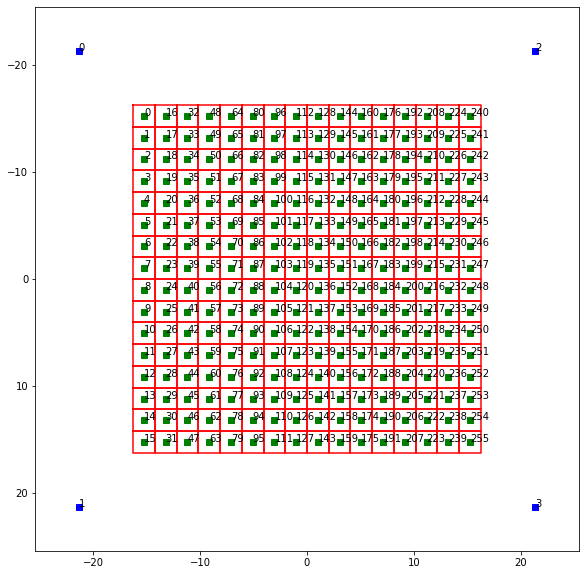

In [18]:
cb_geom.plot()

In [19]:
file_model = Path('models/dot_vision_checker.pth')
detector = DotVisionCheckerDLDetector(file_model)

In [20]:
refiner = OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

In [21]:
files_img = list(Path('data/dot_vision_checker').glob('*.png'))
files_img

[PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/dot_vision_checker/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [22]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [23]:
imgs = []
for file_img in files_img:
    dict_group = _parse_name(file_img.name)
    img = File16bitImg(file_img)
    img.idx_cam = int(dict_group['cam'])-1
    img.idx_cb  = int(dict_group['counter'])-1
    imgs.append(img)

In [24]:
for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - cb: {img.idx_cb}')

SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - cb: 1
SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1 - cam: 2 - cb: 0
SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2 - cam: 2 - cb: 1
SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0


In [25]:
calib = multi_calib(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.00492 - Loss:    5.36733
 - Iteration: 001 - Norm:    0.14985 - Loss:    3.73449
 - Iteration: 002 - Norm:    0.01378 - Loss:    3.72178
 - Iteration: 003 - Norm:    3.80677 - Loss:    3.50140
 - Iteration: 004 - Norm:   60.91136 - Loss:    1.69839
 - Iteration: 005 - Norm:    0.00000 - Loss:    1.69839
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2...
Refining control points for: SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1...
Refining single parameters...
 - Iteration: 000 - Norm:    0.04150 - Loss:  145.18373
 - Iteration: 001 - Norm:    0.13431 - Loss:   83.63355
 - Iteration: 002 - Norm:    0.84358 - Loss:    3.92886
 - Iteration: 003 - Norm:    0.27788 - Loss:    3.59249
 - Iteration: 004 - Norm:   27.32690 - Loss:    2.

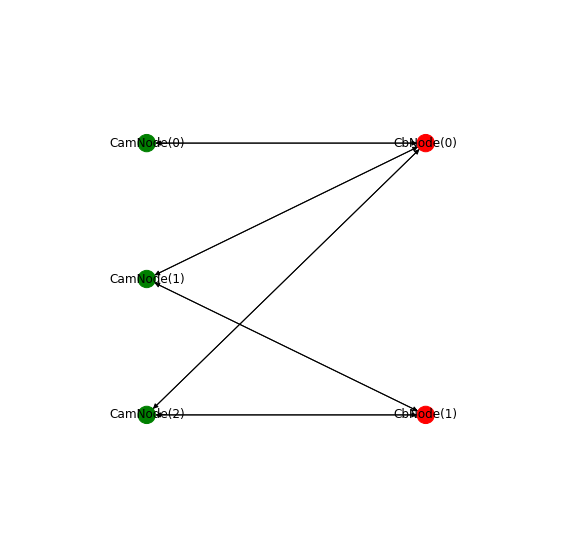

In [26]:
plot_bipartite(*calib['debug']['graph'])

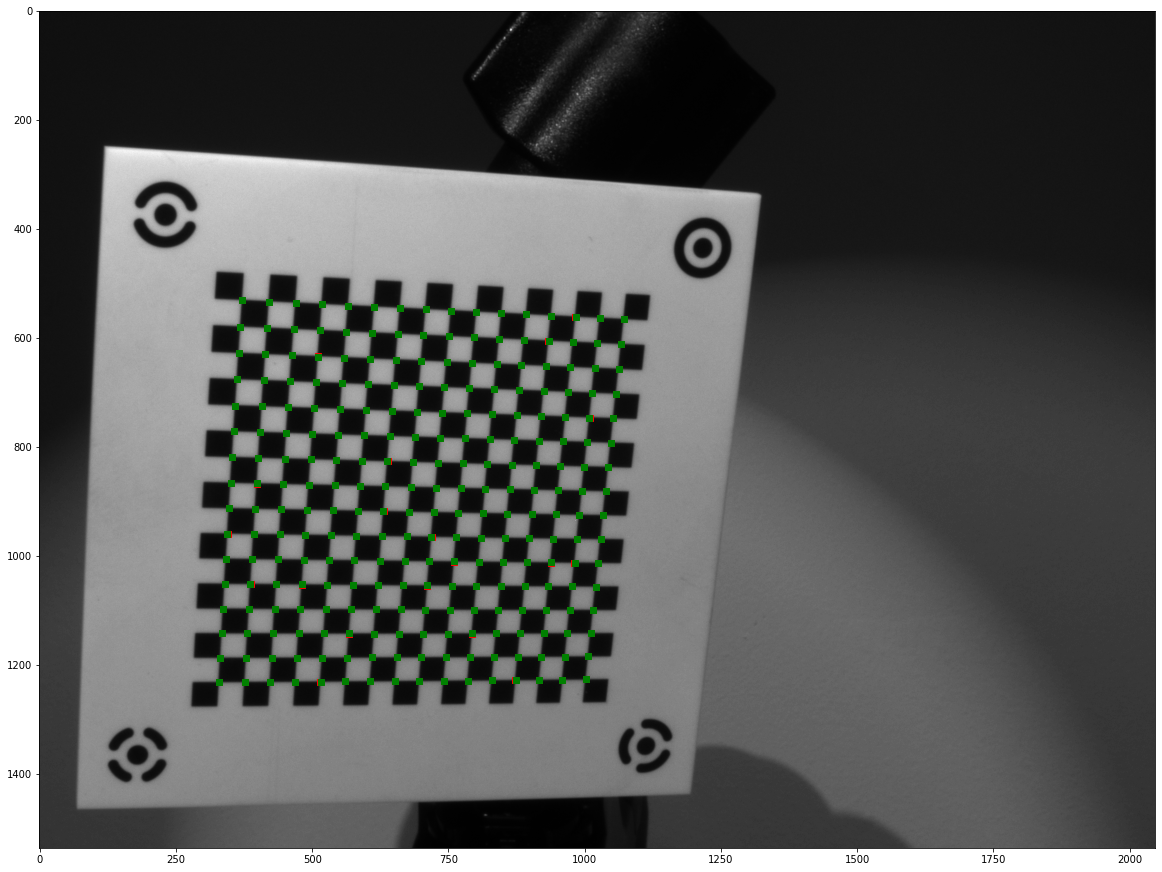

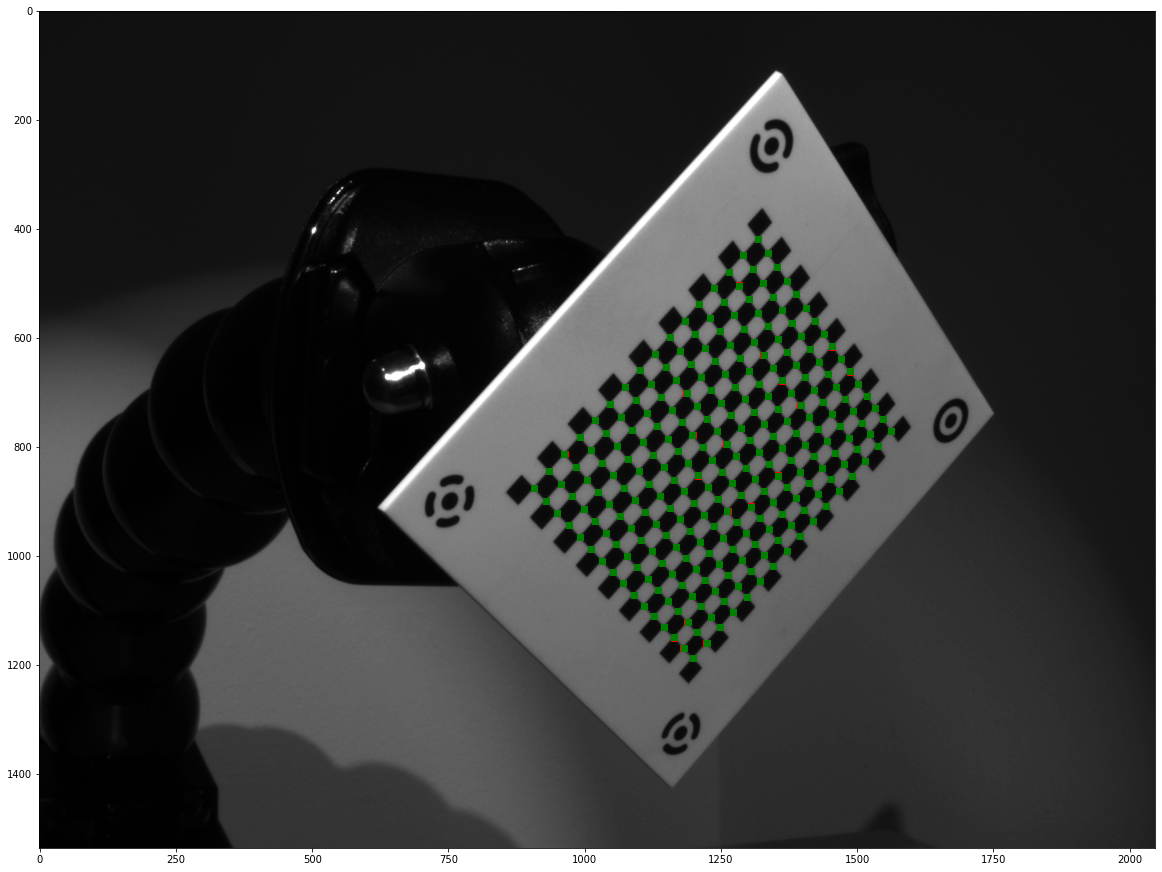

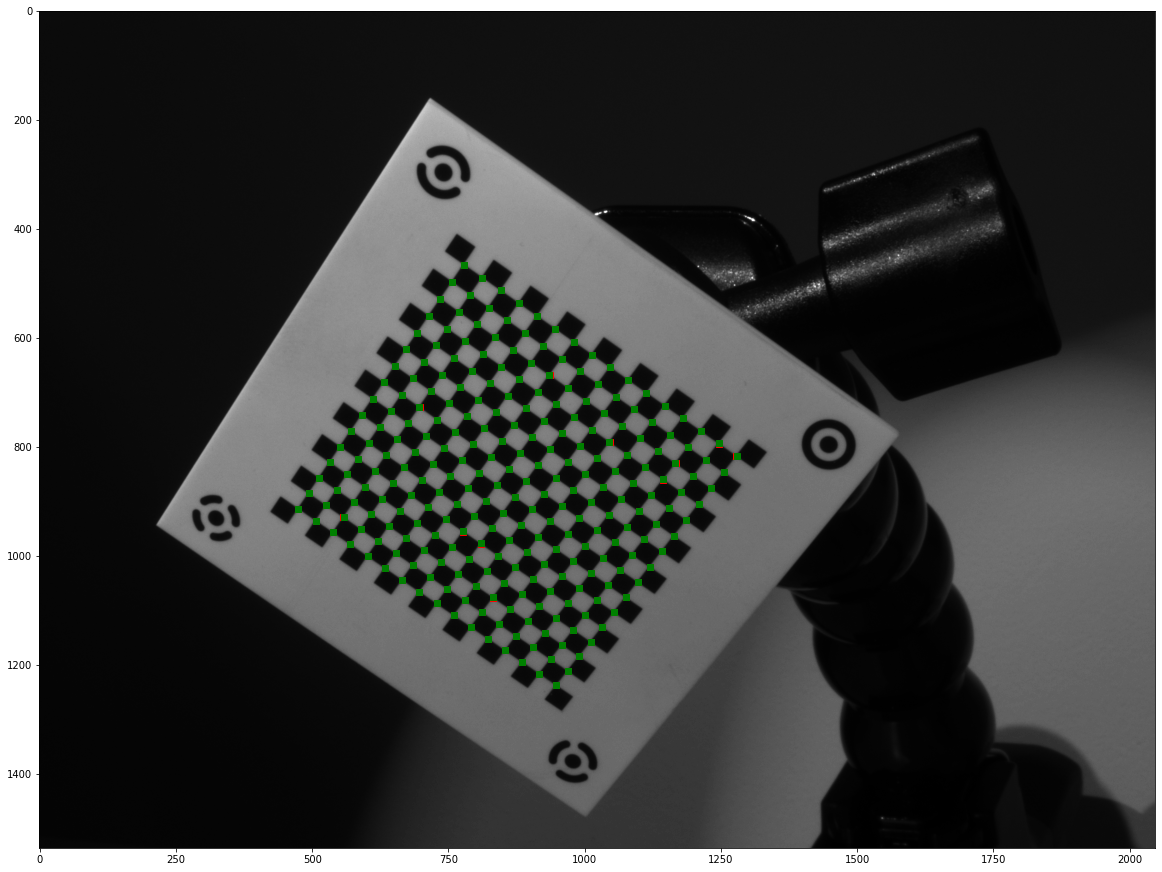

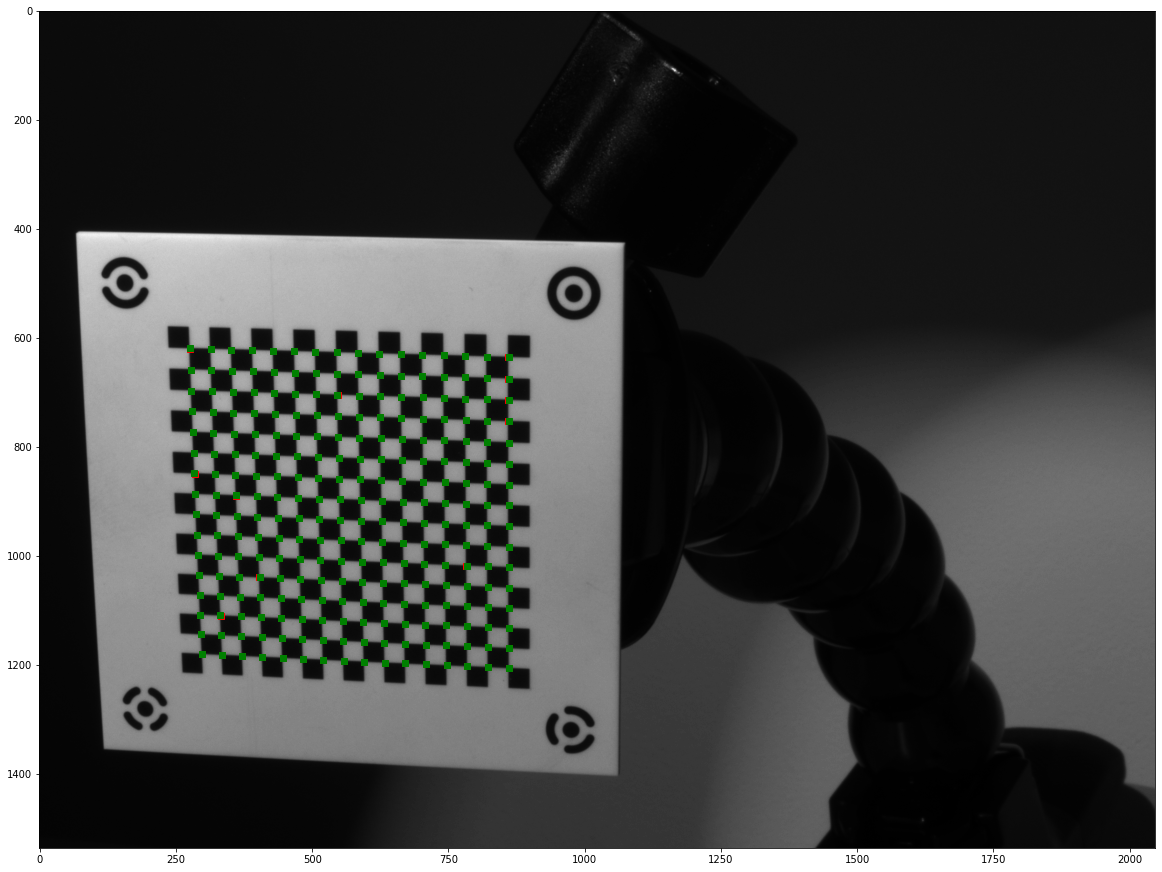

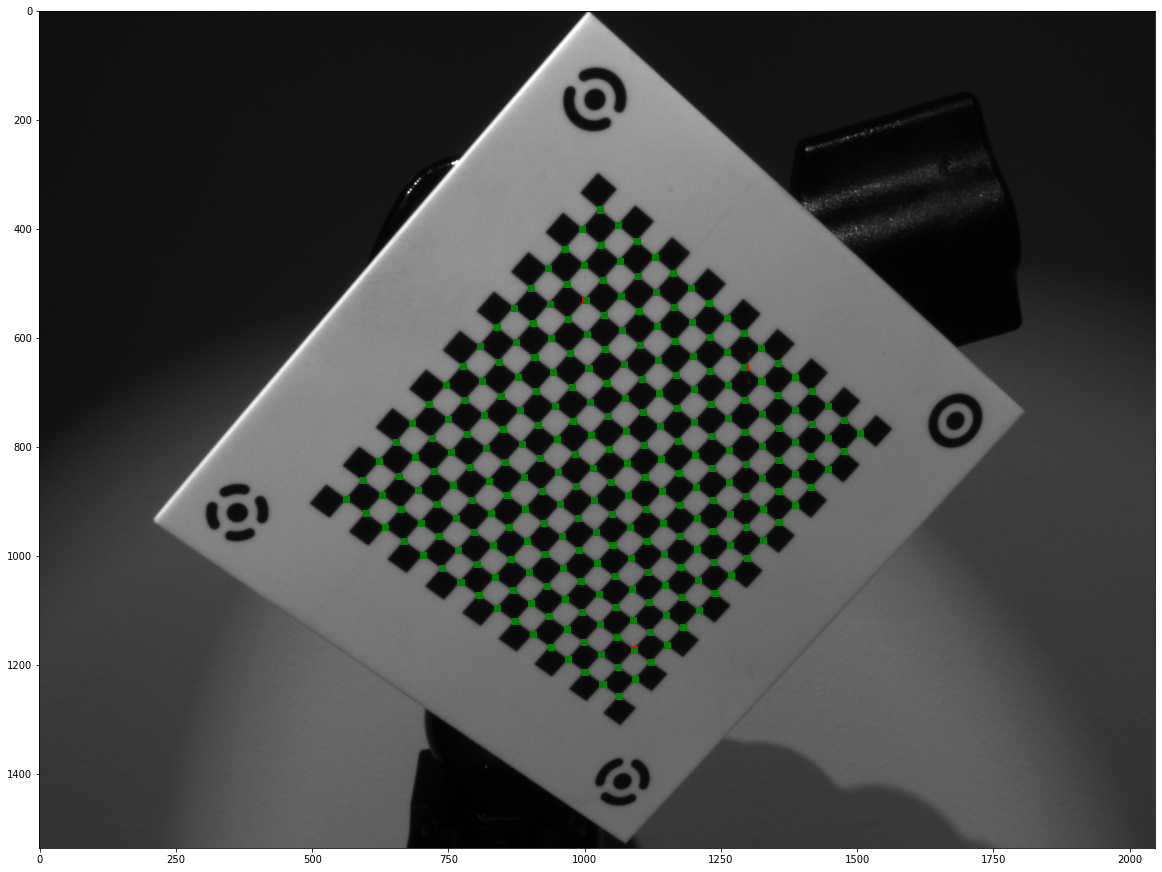

In [27]:
for idx, img in enumerate(calib['imgs']):
    plt.figure(idx, figsize=(20,20))
    plt.imshow(img.array_gs(torch.float), cmap='gray')
    plt.plot(calib['debug']['pss_c_p'][idx][:,0],   calib['debug']['pss_c_p'][idx][:,1],   'rs')
    plt.plot(calib['debug']['pss_c_p_m'][idx][:,0], calib['debug']['pss_c_p_m'][idx][:,1], 'gs')

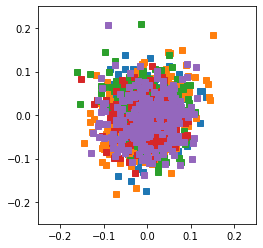

In [28]:
for p1, p2 in zip(calib['debug']['pss_c_p'], calib['debug']['pss_c_p_m']):
    res = (p1-p2)
    plt.plot(res[:,0], res[:,1], 's')
ax = plt.gca()
ax.set_aspect(1)
ax.set_xlim(-0.25, 0.25)
ax.set_ylim(-0.25, 0.25);

In [29]:
torch.save(calib, 'data/dot_vision_checker/calib.pth')

# Build

In [30]:
build_notebook()

<IPython.core.display.Javascript object>

Converted calib.ipynb.
